# Augmentation

> Improving training dynamics even further

Adapted from:

- [https://youtu.be/nlVOG2Nzc3k?si=8a4dKXqkibFS8aHh&t=5063](https://youtu.be/nlVOG2Nzc3k?si=8a4dKXqkibFS8aHh&t=5063)

In [1]:
#| default_exp augmentation

In [2]:
# |export
import random
import re
from contextlib import contextmanager
from functools import partial
from typing import Sequence

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn.functional as F
from einops import rearrange
from IPython.display import Latex, Markdown, display
from torch import nn
from torch.nn import init
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import MulticlassAccuracy
from torchvision import transforms

from slowai.activations import (
    Conv2dWithReLU,
    Hook,
    HooksCallback,
    StoreModuleStatsCB,
    set_seed,
)
from slowai.initializations import (
    BatchTransformCB,
    CNNWithGeneralReLUAndBatchNorm,
    GeneralReLU,
    LSUVHook,
    LSUVInitialization,
    init_leaky_weights,
    set_seed,
)
from slowai.learner import (
    Callback,
    CancelFitException,
    DataLoaders,
    DeviceCB,
    Learner,
    MetricsCB,
    MomentumCB,
    ProgressCB,
    TrainCB,
    TrainLearner,
    batchify,
    before,
    def_device,
    fashion_mnist,
)
from slowai.resnets import CNN, Conv, ResidualConvBlock
from slowai.sgd import BatchSchedulerCB, RecorderCB
from slowai.utils import show_image, show_images

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
set_seed(42)
plt.style.use("ggplot")

Let's redefine the training loop for clarity.

In [4]:
# |export
def train(model, lr=1e-2, n_epochs=2, dls=fashion_mnist(512), extra_cbs=tuple()):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        MetricsCB(MulticlassAccuracy(num_classes=10)),
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        *extra_cbs,
    ]
    learner = TrainLearner(
        model,
        dls,
        F.cross_entropy,
        lr=lr,
        cbs=cbs,
        opt_func=torch.optim.AdamW,
    )
    learner.fit(n_epochs)

## Going wider

Can we get a better result by increasing the width of our network?

We didn't spend much time designing the Residual CNN from the previous notebook. We simply replaced the Conv blocks with Residual Conv blocks, doubling the number of parameters.

In principle, ResNet's are more stable than their CNN counterparts, so we should be able to make the network wider as well as deeper.

In [5]:
class ResNet(nn.Module):
    """Arbitrarily wide and deep residual neural network"""

    def __init__(self, nfs: Sequence[int] = [16, 32, 64, 128, 256, 512], n_outputs=10):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs))

    def get_layers(self, nfs, n_outputs=10):
        layers = [ResidualConvBlock(1, nfs[0], stride=1, ks=5)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            layers.append(ResidualConvBlock(c_in, c_out))
        layers.append(ResidualConvBlock(nfs[-1], n_outputs, act=False))
        return layers

    def forward(self, x):
        x = self.layers(x)
        bs, c, w, h = x.shape
        assert c == self.n_outputs
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

MulticlassAccuracy,loss,epoch,train
0.832,0.471,0,train
0.855,0.410,0,eval
0.911,0.240,1,train
0.916,0.232,1,eval


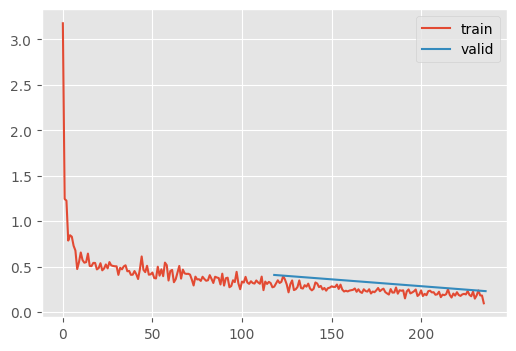

In [6]:
m = ResNet.kaiming()
train(m)

Let's create quick utility to view the shape of the model to check for areas of improvement

In [7]:
# |export
def flops(x, w, h):
    """Estimate flops"""
    if x.dim() < 3:
        return x.numel()
    else:
        return x.numel() * w * h


@contextmanager
def hooks(mods, f):
    hooks_ = []
    for m in mods:
        h = m.register_forward_hook(f)
        hooks_.append(h)
    yield
    for h in hooks_:
        h.remove()


def summarize(m, mods, dls=fashion_mnist(8)):
    xb, _ = dls.peek()
    tp = 0
    tf = 0
    rows = ["|Type|Input|Output|N. params|MFlops|", "|--|--|--|--|--|"]

    if isinstance(mods, str):
        mods_ = []
        for name, mod in m.named_modules():
            if re.match(mods, type(mod).__name__):
                mods_.append(mod)
        mods = mods_

    def summarize_module(m, i, o):
        nonlocal tp, tf, rows
        (i,) = i
        *_, h, w = o.shape
        np = sum(p.numel() for p in m.parameters())
        tp += np
        nflops = sum(flops(o, h, w) for o in m.parameters()) / 1e6
        tf += nflops
        l = f"| {type(m).__name__} | {tuple(i.shape)} | {tuple(o.shape)} | {np:,} | {nflops:.1f}"
        rows.append(l)

    with hooks(mods, summarize_module):
        m(xb)

    rows.append(f"| Total | | | {tp:,} | |")
    display(Markdown("\n".join(rows)))

In [8]:
summarize(ResNet(), "ResidualConvBlock")

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| ResidualConvBlock | (8, 1, 28, 28) | (8, 16, 28, 28) | 6,896 | 5.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| ResidualConvBlock | (8, 256, 2, 2) | (8, 512, 1, 1) | 3,672,576 | 3.7
| ResidualConvBlock | (8, 512, 1, 1) | (8, 10, 1, 1) | 52,150 | 0.1
| Total | | | 4,952,582 | |

One of the important constaints of our model here is that that strides must be configured to downsample the image precisely to `bs x c x 1 x 1`. We can make this more flexible by taking the final feature map (regardless of its height and width) and taking the average.

In [9]:
class ResNetWithGlobalPooling(nn.Module):
    """Arbitrarily wide and deep residual neural network"""

    def __init__(self, nfs: Sequence[int] = [16, 32, 64, 128, 256, 512], n_outputs=10):
        super().__init__()
        self.nfs = nfs
        self.n_outputs = n_outputs
        self.layers = nn.Sequential(*self.get_layers(nfs, n_outputs))
        self.lin = nn.Linear(nfs[-1], n_outputs)
        self.norm = nn.BatchNorm1d(n_outputs)

    def get_layers(self, nfs, n_outputs=10):
        layers = [ResidualConvBlock(1, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            block = ResidualConvBlock(c_in, c_out)
            layers.append(block)
        return layers

    def forward(self, x):
        x = self.layers(x)
        bs, c, w, h = x.shape
        x = x.mean((2, 3))  # Global Average Pooling
        x = self.lin(x)
        x = self.norm(x)
        return x

    @classmethod
    def kaiming(cls, *args, **kwargs):
        model = cls(*args, **kwargs)
        model.apply(init_leaky_weights)
        return model

In [10]:
nfs = [
    16,
    32,
    64,
    128,
    256,  # 👈 notice that this leaves the feature map at 2x2...
]
m = ResNetWithGlobalPooling.kaiming(nfs)
summarize(m, "ResidualConvBlock|Linear")

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| ResidualConvBlock | (8, 1, 28, 28) | (8, 16, 28, 28) | 6,896 | 5.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| Linear | (8, 256) | (8, 10) | 2,570 | 0.0
| Total | | | 1,230,426 | |

MulticlassAccuracy,loss,epoch,train
0.848,0.579,0,train
0.860,0.421,0,eval
0.915,0.284,1,train
0.916,0.268,1,eval


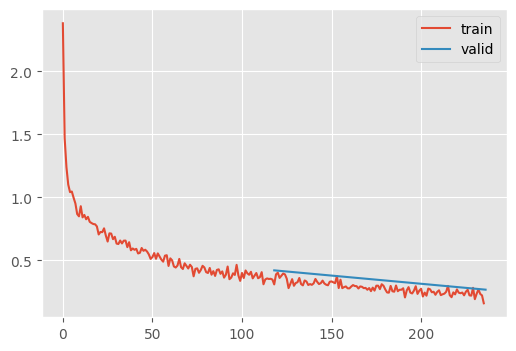

In [11]:
# ...but it still works!
train(m)

Can we reduce the number of parameters to save on memory? Indeed. One thing to focus on is the first ResidualConvBlock which has the most MegaFlops, because it applies the 16 kernels to each pixel. We can try replacing it with a Conv.

In [12]:
class ResNetWithGlobalPoolingInitialConv(ResNetWithGlobalPooling):
    """Arbitrarily wide and deep residual neural network"""

    def get_layers(self, nfs, n_outputs=10):
        layers = [Conv(1, nfs[0], ks=5, stride=1)]
        for c_in, c_out in zip(nfs, nfs[1:]):
            block = ResidualConvBlock(c_in, c_out)
            layers.append(block)
        return layers

In [13]:
m = ResNetWithGlobalPoolingInitialConv.kaiming()
summarize(m, [*m.layers, m.lin, m.norm])

|Type|Input|Output|N. params|MFlops|
|--|--|--|--|--|
| Conv | (8, 1, 28, 28) | (8, 16, 28, 28) | 432 | 0.3
| ResidualConvBlock | (8, 16, 28, 28) | (8, 32, 14, 14) | 14,496 | 2.8
| ResidualConvBlock | (8, 32, 14, 14) | (8, 64, 7, 7) | 57,664 | 2.8
| ResidualConvBlock | (8, 64, 7, 7) | (8, 128, 4, 4) | 230,016 | 3.7
| ResidualConvBlock | (8, 128, 4, 4) | (8, 256, 2, 2) | 918,784 | 3.7
| ResidualConvBlock | (8, 256, 2, 2) | (8, 512, 1, 1) | 3,672,576 | 3.7
| Linear | (8, 512) | (8, 10) | 5,130 | 0.0
| BatchNorm1d | (8, 10) | (8, 10) | 20 | 0.0
| Total | | | 4,899,118 | |

MulticlassAccuracy,loss,epoch,train
0.850,0.564,0,train
0.851,0.457,0,eval
0.914,0.280,1,train
0.917,0.265,1,eval


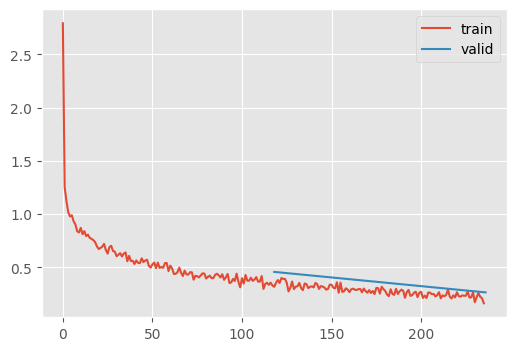

In [14]:
train(m)

This approach yeilds a small, flexible and competitive model. What happens if we train for a while?

MulticlassAccuracy,loss,epoch,train
0.847,0.662,0,train
0.875,0.529,0,eval
0.899,0.455,1,train
0.882,0.427,1,eval
0.905,0.353,2,train
0.885,0.371,2,eval
0.913,0.289,3,train
0.861,0.420,3,eval
0.919,0.249,4,train
0.826,0.523,4,eval


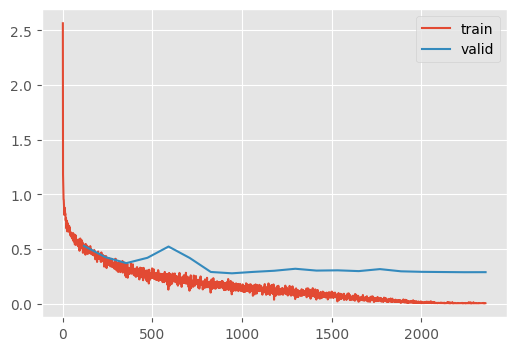

In [15]:
train(ResNetWithGlobalPoolingInitialConv.kaiming(), n_epochs=20)

The near perfect training accuracy indicates that the model is simply memorizing the dataset and failing to generalize.

Can we use another regularization technique to improve generalization? No.

:::{.callout-tip}
## Weight Decay and Batchnorm do not work together
We've posited that weight decay, as a regularization, prevents memorization. However,
batch norm has a single set of coefficients that scale the layer output. Since weight decay also scales the layer weight, the model is able to "cheat." Jeremy says to avoid weight decay and rely on a scheduler.
:::

Instead, let's try "Augmentation" to create pseudo-new data that the model must learn to account for.

## Augmentation

Recall, we implemented the `with_transforms` method on the `Dataloaders` class in the `Learner` notebook.

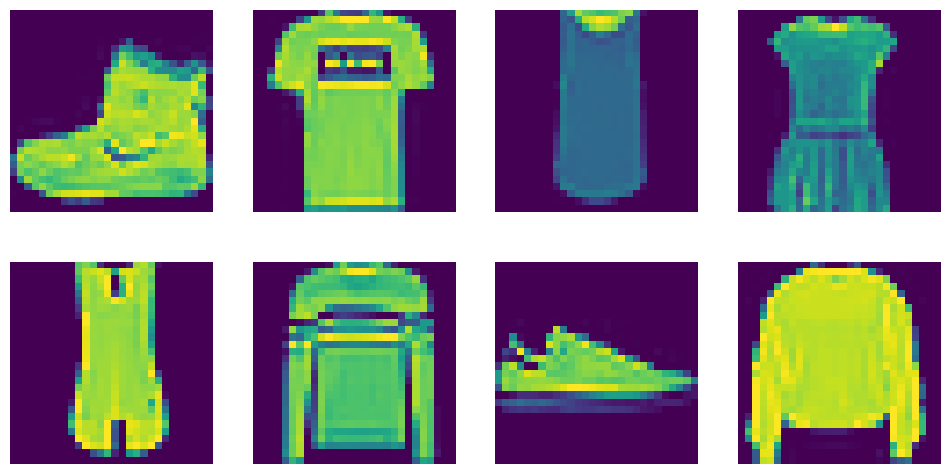

In [16]:
tfms = [
    transforms.RandomCrop(28, padding=1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.26], [0.35]),
]
tfmsc = transforms.Compose(tfms)

dls = fashion_mnist(512).with_transforms(
    {"image": batchify(tfmsc)},
    lazy=True,
    splits=["train"],
)

xb, _ = dls.peek()
show_images(xb[:8, ...])

In [17]:
pixels = xb.view(-1)
pixels.mean(), pixels.std()

(tensor(0.0647), tensor(1.0080))

MulticlassAccuracy,loss,epoch,train
0.811,0.746,0,train
0.856,0.538,0,eval
0.875,0.514,1,train
0.862,0.476,1,eval
0.886,0.404,2,train
0.877,0.397,2,eval
0.891,0.339,3,train
0.840,0.456,3,eval
0.897,0.305,4,train
0.849,0.443,4,eval


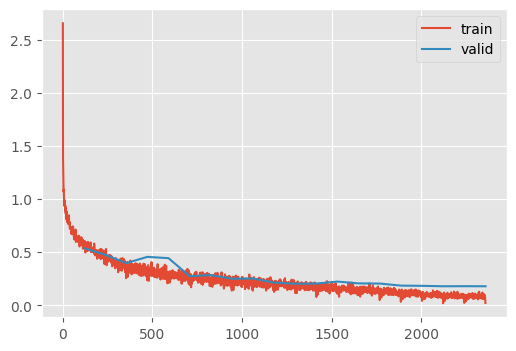

In [18]:
m_with_augmentation = ResNetWithGlobalPoolingInitialConv.kaiming()
train(m_with_augmentation, dls=dls, n_epochs=20)

## Test Time Augmentation

Giving the model mulitple oppertunities to see the input can further improve the output.

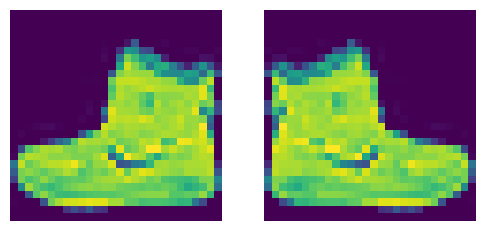

In [19]:
xbf = torch.flip(xb, dims=(3,))
show_images([xb[0, ...], xbf[0, ...]])

In [31]:
def accuracy(model_predict_f, model, device=def_device):
    dls = fashion_mnist(512)
    n, n_correct = 0, 0
    for xb, yb in dls["test"]:
        xb = xb.to(device)
        yb = yb.to(device)
        yp = model_predict_f(xb, model)
        n += len(yb)
        n_correct += (yp == yb).float().sum().item()
    return n_correct / n


def pred_normal(xb, m):
    return m_with_augmentation(xb).argmax(axis=1)

Let's check the normal accuracy

In [32]:
accuracy(pred_normal, m_with_augmentation)

0.9399

Now, we can compare that to averaging the outputs when looking at both flips

In [33]:
def pred_with_test_time_augmentation(xb, m):
    yp = m(xb)
    xbf = torch.flip(xb, dims=(3,))
    ypf = m_with_augmentation(xbf)
    return (yp + ypf).argmax(axis=1)


accuracy(pred_with_test_time_augmentation, m_with_augmentation)

0.9414

This is a slight improvement!

## RandCopy

Another thing to try is creating new-ish images by cutting and pasting segments of the image onto different locations. A benefit to this approach is that the image should retain its pixel brightness distribution. (Compare to, for example, adding black will push the distribution downwards)

In [23]:
# |export
class RandCopy(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct = pct
        self.max_num = max_num

    def forward(self, x):
        x = x.clone()
        for i in range(random.randint(0, self.max_num)):
            *_, w, h = x.shape
            szx = int(self.pct * w)
            szy = int(self.pct * h)
            stx1 = int(random.random() * (1 - self.pct) * w)
            sty1 = int(random.random() * (1 - self.pct) * h)
            stx2 = int(random.random() * (1 - self.pct) * w)
            sty2 = int(random.random() * (1 - self.pct) * h)
            segment = x[..., stx2 : stx2 + szx, sty2 : sty2 + szy]
            x[..., stx1 : stx1 + szx, sty1 : sty1 + szy] = segment
        return x

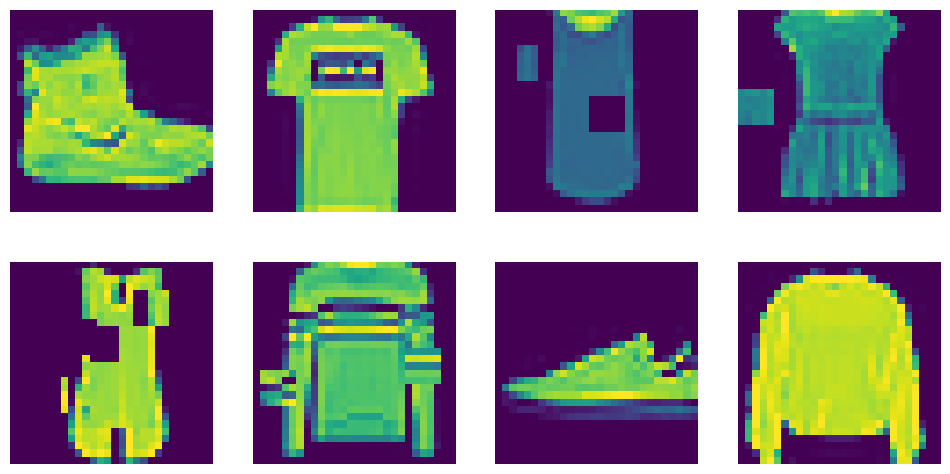

In [24]:
tfmsc2 = transforms.Compose([*tfms, RandCopy()])

dls2 = fashion_mnist(512).with_transforms(
    {"image": batchify(tfmsc2)},
    lazy=True,
    splits=["train"],
)

xb, _ = dls2.peek()
show_images(xb[:8, ...])

MulticlassAccuracy,loss,epoch,train
0.782,0.814,0,train
0.854,0.532,0,eval
0.851,0.574,1,train
0.866,0.440,1,eval
0.865,0.457,2,train
0.873,0.384,2,eval
0.873,0.386,3,train
0.879,0.347,3,eval
0.880,0.352,4,train
0.879,0.330,4,eval


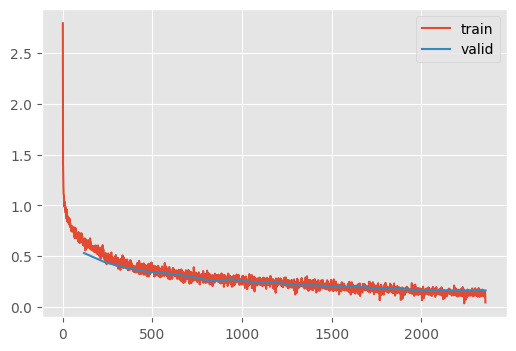

In [25]:
m_with_more_augmentation = ResNetWithGlobalPoolingInitialConv.kaiming()
train(m_with_more_augmentation, dls=dls2, n_epochs=20)

In [36]:
accuracy(pred_normal, m_with_more_augmentation)

0.9404

In [37]:
accuracy(pred_with_test_time_augmentation, m_with_more_augmentation)

0.9439

We're _so_ close to Jeremy's 94.6% accuracy

In [26]:
#| hide
import nbdev

nbdev.nbdev_export()

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.10/site-packages/nbdev/export.py:54: UserWarning: Notebook '/Users/jeremiahfisher/Code/SlowAI/nbs/hack.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
